## 1. 환경 설정 및 라이브러리 임포트

In [1]:
# 필수 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RDKit 라이브러리
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole

# PyTorch Geometric (그래프 데이터 처리용)
import torch
from torch_geometric.data import Data

# 경고 메시지 무시
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

print("✓ 라이브러리 임포트 완료")
print(f"RDKit 버전: {Chem.rdBase.rdkitVersion}")
print(f"PyTorch 버전: {torch.__version__}")

/home/jeheon/miniforge3/envs/molclr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ 라이브러리 임포트 완료
RDKit 버전: 2025.09.4
PyTorch 버전: 2.2.2+cu118


In [2]:
def display_mol_with_options(mol, **draw_options):
    """
    그리기 옵션을 적용하여 분자를 표시
    
    Args:
        mol: RDKit Mol 객체
        **draw_options: IPythonConsole.drawOptions에 적용할 옵션들
            - addAtomIndices: 원자 인덱스 표시
            - addBondIndices: 결합 인덱스 표시
            - addStereoAnnotation: 입체화학 표시
            등...
    
    Example:
        display_mol_with_options(mol, addBondIndices=True)
        display_mol_with_options(mol, addAtomIndices=True, addBondIndices=True)
    """
    # 현재 옵션 저장
    old_options = {}
    for key, value in draw_options.items():
        old_options[key] = getattr(IPythonConsole.drawOptions, key)
        setattr(IPythonConsole.drawOptions, key, value)
    
    # 분자 표시
    display(mol)
    
    # 원래 옵션으로 복원
    for key, value in old_options.items():
        setattr(IPythonConsole.drawOptions, key, value)

print("✓ 헬퍼 함수 정의 완료")

✓ 헬퍼 함수 정의 완료


## 2. SMILES (Simplified Molecular Input Line Entry System)

### 2.1 SMILES란?

SMILES는 분자 구조를 텍스트 문자열로 표현하는 방법입니다.

**주요 규칙:**
- 원자: `C` (탄소), `N` (질소), `O` (산소), `S` (황) 등
- 단일 결합: 생략 가능 (예: `CC` = C-C)
- 이중 결합: `=` (예: `C=C`)
- 삼중 결합: `#` (예: `C#C`)
- 고리 구조: 숫자로 표시 (예: `C1CCCCC1` = 사이클로헥산)
- 가지: 괄호 `()` 사용
- 방향족: 소문자 (예: `c1ccccc1` = 벤젠)

**예시:**
- 에탄올: `CCO` 또는 `C-C-O`
- 아세트산: `CC(=O)O`
- 벤젠: `c1ccccc1`
- 톨루엔: `Cc1ccccc1`

In [3]:
# SMILES 예제
smiles_examples = {
    '메탄': 'C',
    '에탄': 'CC',
    '에탄올': 'CCO',
    '아세트산': 'CC(=O)O',
    '벤젠': 'c1ccccc1',
    '톨루엔': 'Cc1ccccc1',
    '카페인': 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',
    '아스피린': 'CC(=O)Oc1ccccc1C(=O)O'
}

print("SMILES 예제:")
print("=" * 50)
for name, smiles in smiles_examples.items():
    print(f"{name:12s}: {smiles}")
print("=" * 50)

SMILES 예제:
메탄          : C
에탄          : CC
에탄올         : CCO
아세트산        : CC(=O)O
벤젠          : c1ccccc1
톨루엔         : Cc1ccccc1
카페인         : CN1C=NC2=C1C(=O)N(C(=O)N2C)C
아스피린        : CC(=O)Oc1ccccc1C(=O)O


### 2.2 SMILES 시각화

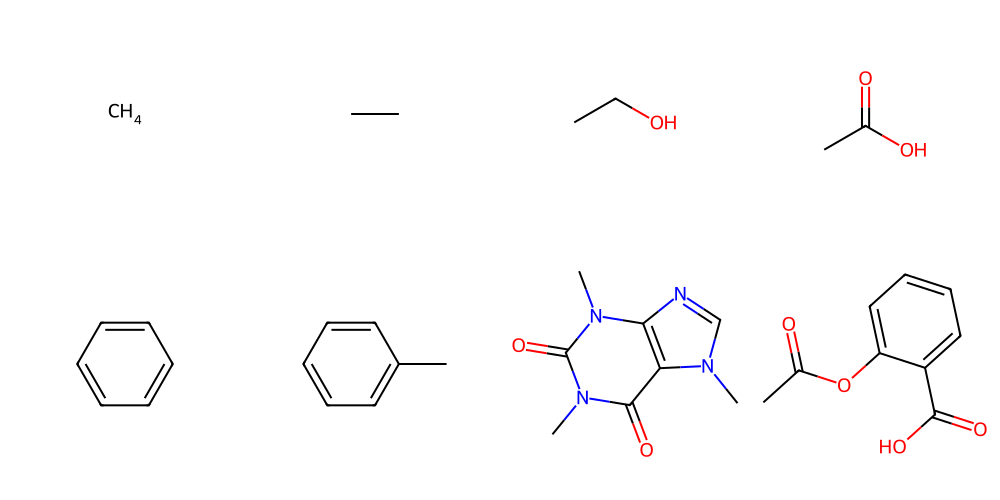

In [4]:
# 여러 분자를 한 번에 시각화
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_examples.values()]
legends = list(smiles_examples.keys())

img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(250, 250), 
                            legends=legends, returnPNG=False)
img

## 3. RDKit Mol 객체 생성 및 조작

### 3.1 Mol 객체 생성

`Mol` 객체는 RDKit에서 분자를 표현하는 핵심 데이터 구조입니다.

분자: 아스피린
SMILES: CC(=O)Oc1ccccc1C(=O)O
Mol 객체 타입: <class 'rdkit.Chem.rdchem.Mol'>
유효한 분자인가? True


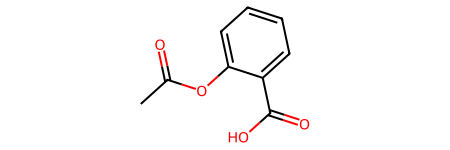

In [5]:
# SMILES로부터 Mol 객체 생성
smiles = 'CC(=O)Oc1ccccc1C(=O)O'  # 아스피린
mol = Chem.MolFromSmiles(smiles)

print(f"분자: 아스피린")
print(f"SMILES: {smiles}")
print(f"Mol 객체 타입: {type(mol)}")
print(f"유효한 분자인가? {mol is not None}")

# 분자 시각화
mol

### 3.2 분자 정보 추출

In [6]:
# 기본 정보
num_atoms = mol.GetNumAtoms()
num_bonds = mol.GetNumBonds()
num_heavy_atoms = mol.GetNumHeavyAtoms()  # 수소 제외

print("분자 구조 정보:")
print("=" * 50)
print(f"총 원자 수: {num_atoms}")
print(f"중원자 수 (수소 제외): {num_heavy_atoms}")
print(f"결합 수: {num_bonds}")
print("=" * 50)

# 분자 특성 (Descriptors)
print("\n분자 특성:")
print("=" * 50)
print(f"분자량: {Descriptors.MolWt(mol):.2f}")
print(f"LogP (지질 용해도): {Descriptors.MolLogP(mol):.2f}")
print(f"수소 결합 공여체 수: {Descriptors.NumHDonors(mol)}")
print(f"수소 결합 수용체 수: {Descriptors.NumHAcceptors(mol)}")
print(f"회전 가능한 결합 수: {Descriptors.NumRotatableBonds(mol)}")
print(f"방향족 고리 수: {Descriptors.NumAromaticRings(mol)}")
print("=" * 50)

분자 구조 정보:
총 원자 수: 13
중원자 수 (수소 제외): 13
결합 수: 13

분자 특성:
분자량: 180.16
LogP (지질 용해도): 1.31
수소 결합 공여체 수: 1
수소 결합 수용체 수: 3
회전 가능한 결합 수: 2
방향족 고리 수: 1


### 3.3 수소 원자 추가

SMILES는 일반적으로 수소를 생략합니다. 명시적으로 수소를 추가할 수 있습니다.

수소 추가 전: 3 개 원자
수소 추가 후: 9 개 원자


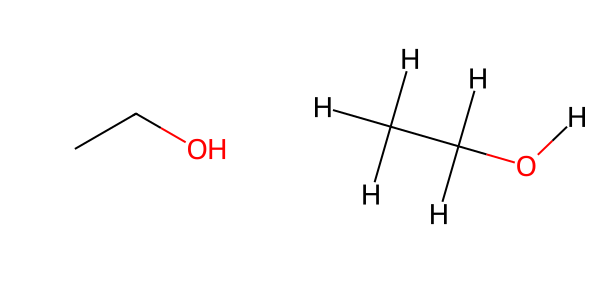

In [7]:
# 수소 추가 전
smiles = 'CCO'  # 에탄올
mol_no_h = Chem.MolFromSmiles(smiles)
print(f"수소 추가 전: {mol_no_h.GetNumAtoms()} 개 원자")

# 수소 추가
mol_with_h = Chem.AddHs(mol_no_h)
print(f"수소 추가 후: {mol_with_h.GetNumAtoms()} 개 원자")

# 시각화 비교
img = Draw.MolsToGridImage([mol_no_h, mol_with_h], 
                            molsPerRow=2, subImgSize=(300, 300),
                            legends=['수소 생략', '수소 표시'])
img

## 4. 원자(Atom) 특징 추출

GNN에서 사용할 원자 특징 벡터를 추출합니다. 각 원자의 속성(원자 번호, degree, 수소 수, 전하, 방향족 여부, 혼성 궤도 등)을 수치 벡터로 변환합니다.

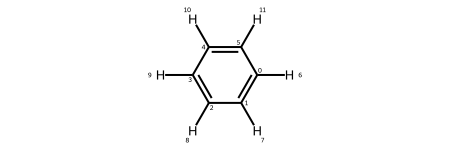

벤젠 분자의 원자 특징:
Idx   Symbol   AtomicNum    Degree   NumHs    Charge   Aromatic   Hybrid
0     C        6            3        0        0        1          3
1     C        6            3        0        0        1          3
2     C        6            3        0        0        1          3
3     C        6            3        0        0        1          3
4     C        6            3        0        0        1          3
5     C        6            3        0        0        1          3
6     H        1            1        0        0        0          0
7     H        1            1        0        0        0          0
8     H        1            1        0        0        0          0
9     H        1            1        0        0        0          0
10    H        1            1        0        0        0          0
11    H        1            1        0        0        0          0


In [8]:
def get_atom_features(atom):
    """
    원자의 특징 벡터를 추출
    """
    features = []
    
    # 1. 원자 타입 (원자 번호)
    features.append(atom.GetAtomicNum())
    
    # 2. Degree (연결된 원자 수)
    features.append(atom.GetDegree())
    
    # 3. 총 수소 수
    features.append(atom.GetTotalNumHs())
    
    # 4. 형식 전하 (Formal Charge)
    features.append(atom.GetFormalCharge())
    
    # 5. 방향족 여부 (0 or 1)
    features.append(int(atom.GetIsAromatic()))
    
    # 6. Hybridization (혼성 궤도)
    features.append(int(atom.GetHybridization()))
    
    return features


# 벤젠 분자로 테스트
mol = Chem.MolFromSmiles('c1ccccc1')
mol = Chem.AddHs(mol)
display_mol_with_options(mol, addAtomIndices=True)

print("벤젠 분자의 원자 특징:")
print("=" * 100)
print(f"{'Idx':<5} {'Symbol':<8} {'AtomicNum':<12} {'Degree':<8} {'NumHs':<8} {'Charge':<8} {'Aromatic':<10} {'Hybrid'}")
print("=" * 100)

for atom in mol.GetAtoms():
    features = get_atom_features(atom)
    print(f"{atom.GetIdx():<5} {atom.GetSymbol():<8} {features[0]:<12} {features[1]:<8} {features[2]:<8} {features[3]:<8} {features[4]:<10} {features[5]}")

print("=" * 100)

## 5. 결합(Bond) 특징 추출

GNN에서 사용할 결합(엣지) 특징 벡터를 추출합니다. 각 결합의 속성(결합 타입, 방향족 여부, 공액 여부, 고리 포함 여부)을 수치 벡터로 변환합니다.

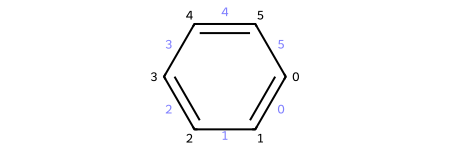

벤젠의 결합 특징:
Bond     Start-End    Type     Aromatic   Conjug     InRing
0        0-1          3        1          1          1
1        1-2          3        1          1          1
2        2-3          3        1          1          1
3        3-4          3        1          1          1
4        4-5          3        1          1          1
5        5-0          3        1          1          1


In [9]:
from rdkit.Chem import BondType

def get_bond_features(bond):
    """
    결합의 특징 벡터를 추출
    """
    features = []
    
    # 1. 결합 타입 (SINGLE, DOUBLE, TRIPLE, AROMATIC)
    bt = bond.GetBondType()
    bond_type_map = {
        BondType.SINGLE: 0,
        BondType.DOUBLE: 1,
        BondType.TRIPLE: 2,
        BondType.AROMATIC: 3
    }
    features.append(bond_type_map.get(bt, 0))
    
    # 2. 방향족 결합 여부
    features.append(int(bond.GetIsAromatic()))
    
    # 3. 공액 결합 여부
    features.append(int(bond.GetIsConjugated()))
    
    # 4. 고리 내 결합 여부
    features.append(int(bond.IsInRing()))
    
    return features


# 벤젠으로 테스트
mol = Chem.MolFromSmiles('c1ccccc1')
display_mol_with_options(mol, addBondIndices=True, addAtomIndices=True)

print("벤젠의 결합 특징:")
print("=" * 70)
print(f"{'Bond':<8} {'Start-End':<12} {'Type':<8} {'Aromatic':<10} {'Conjug':<10} {'InRing'}")
print("=" * 70)

for bond in mol.GetBonds():
    features = get_bond_features(bond)
    start_end = f"{bond.GetBeginAtomIdx()}-{bond.GetEndAtomIdx()}"
    print(f"{bond.GetIdx():<8} {start_end:<12} {features[0]:<8} {features[1]:<10} {features[2]:<10} {features[3]}")

print("=" * 70)

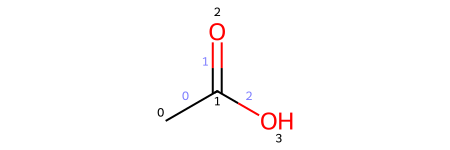

아세트산의 결합 특징:
Bond     Start-End    Type     Aromatic   Conjug     InRing
0        0-1          0        0          0          0
1        1-2          1        0          1          0
2        1-3          0        0          1          0


In [10]:
# 아세트산 분자
mol = Chem.MolFromSmiles('CC(=O)O')
display_mol_with_options(mol, addBondIndices=True, addAtomIndices=True)

print("아세트산의 결합 특징:")
print("=" * 70)
print(f"{'Bond':<8} {'Start-End':<12} {'Type':<8} {'Aromatic':<10} {'Conjug':<10} {'InRing'}")
print("=" * 70)

for bond in mol.GetBonds():
    features = get_bond_features(bond)
    start_end = f"{bond.GetBeginAtomIdx()}-{bond.GetEndAtomIdx()}"
    print(f"{bond.GetIdx():<8} {start_end:<12} {features[0]:<8} {features[1]:<10} {features[2]:<10} {features[3]}")

print("=" * 70)

## 6. 분자 그래프 구조

분자를 그래프로 표현:
- **노드(Node)**: 원자
- **엣지(Edge)**: 화학 결합

### 6.1 인접 행렬 (Adjacency Matrix)

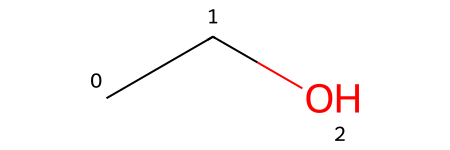

에탄올(CCO)의 구조: C(0) - C(1) - O(2)
각 숫자는 원자의 인덱스입니다. 인접 행렬과 비교해보세요!
에탄올(CCO)의 인접 행렬:
원자: C(0) - C(1) - O(2)

인접 행렬:
[[0 1 0]
 [1 0 1]
 [0 1 0]]


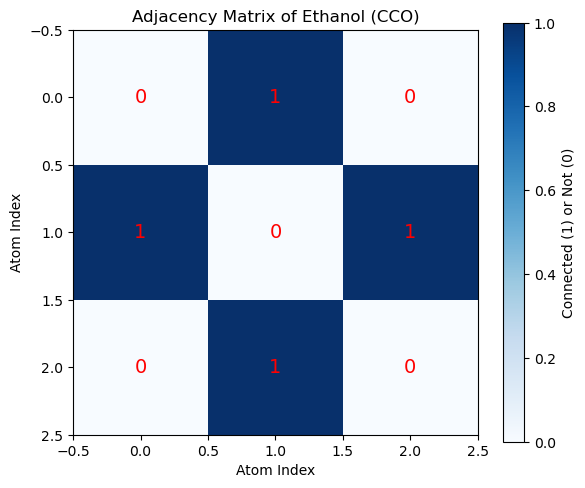

In [11]:
# 에탄올 분자 시각화 (atom index 포함)
ethanol = Chem.MolFromSmiles('CCO')
display_mol_with_options(ethanol, addAtomIndices=True)

print("에탄올(CCO)의 구조: C(0) - C(1) - O(2)")
print("각 숫자는 원자의 인덱스입니다. 인접 행렬과 비교해보세요!")


def get_adjacency_matrix(mol):
    """
    분자의 인접 행렬 생성
    """
    num_atoms = mol.GetNumAtoms()
    adj_matrix = np.zeros((num_atoms, num_atoms), dtype=int)
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1  # 무방향 그래프
    
    return adj_matrix


# 에탄올로 테스트
adj_matrix = get_adjacency_matrix(ethanol)

print("에탄올(CCO)의 인접 행렬:")
print("=" * 30)
print("원자: C(0) - C(1) - O(2)")
print("\n인접 행렬:")
print(adj_matrix)
print("=" * 30)

# 시각화
plt.figure(figsize=(6, 5))
plt.imshow(adj_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar(label='Connected (1) or Not (0)')
plt.title('Adjacency Matrix of Ethanol (CCO)')
plt.xlabel('Atom Index')
plt.ylabel('Atom Index')
for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix)):
        plt.text(j, i, str(adj_matrix[i, j]), 
                ha='center', va='center', color='red', fontsize=14)
plt.tight_layout()
plt.show()

### 6.2 엣지 리스트 (Edge List)

GNN에서는 주로 엣지 리스트 형태를 사용합니다.

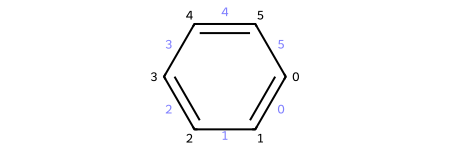


인접 행렬:
[[0 1 0 0 0 1]
 [1 0 1 0 0 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 0 0 1 0 1]
 [1 0 0 0 1 0]]

벤젠의 엣지 리스트:
Shape: (2, 12)

엣지 (source → target):
[[0 1 1 2 2 3 3 4 4 5 5 0]
 [1 0 2 1 3 2 4 3 5 4 0 5]]


In [12]:
def get_edge_list(mol):
    """
    분자의 엣지 리스트 생성 (양방향)
    """
    edges = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges.append([i, j])
        edges.append([j, i])  # 양방향
    
    return np.array(edges).T  # [2, num_edges] 형태


# 벤젠으로 테스트
mol = Chem.MolFromSmiles('c1ccccc1')
display_mol_with_options(mol, addBondIndices=True, addAtomIndices=True)

# 인접 행렬
adj_matrix = get_adjacency_matrix(mol)

print("\n인접 행렬:")
print(adj_matrix)
print("=" * 40)

# 엣지 리스트
edge_list = get_edge_list(mol)

print("\n벤젠의 엣지 리스트:")
print(f"Shape: {edge_list.shape}")
print(f"\n엣지 (source → target):")
print(edge_list)

## 7. GNN 학습을 위한 데이터 전처리

### 7.1 PyTorch Geometric Data 객체 생성

PyTorch Geometric의 `Data` 객체는 그래프 데이터를 표현하는 표준 형식입니다.

In [13]:
def mol_to_graph_data(smiles, y=None):
    """
    SMILES를 PyTorch Geometric Data 객체로 변환
    
    Args:
        smiles: SMILES 문자열
        y: 타겟 값 (optional)
    
    Returns:
        Data: PyTorch Geometric Data 객체
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    mol = Chem.AddHs(mol)
    
    # 1. 노드 특징 (원자 특징)
    atom_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),           # 원자 번호
            atom.GetDegree(),              # Degree
            atom.GetTotalNumHs(),          # 수소 수
            atom.GetFormalCharge(),        # 형식 전하
            int(atom.GetIsAromatic()),     # 방향족
            int(atom.GetHybridization())   # Hybridization
        ]
        atom_features.append(features)
    
    x = torch.tensor(atom_features, dtype=torch.float)
    
    # 2. 엣지 인덱스
    edge_indices = []
    edge_attrs = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # 양방향 엣지
        edge_indices.append([i, j])
        edge_indices.append([j, i])
        
        # 엣지 특징
        bond_features = get_bond_features(bond)
        edge_attrs.append(bond_features)
        edge_attrs.append(bond_features)  # 양방향 동일
    
    edge_index = torch.tensor(edge_indices, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)
    
    # 3. Data 객체 생성
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    if y is not None:
        data.y = torch.tensor([y], dtype=torch.float)
    
    return data


# 테스트
smiles = 'CC(=O)O'  # 아세트산
graph_data = mol_to_graph_data(smiles, y=4.76)  # pKa 값

print("아세트산의 그래프 데이터:")
print("=" * 50)
print(f"노드 특징 (x): {graph_data.x.shape}")
print(f"엣지 인덱스 (edge_index): {graph_data.edge_index.shape}")
print(f"엣지 특징 (edge_attr): {graph_data.edge_attr.shape}")
print(f"타겟 (y): {graph_data.y}")
print("=" * 50)

print(f"\n노드 특징:")
print(graph_data.x)

print(f"\n엣지 인덱스:")
print(graph_data.edge_index)

아세트산의 그래프 데이터:
노드 특징 (x): torch.Size([8, 6])
엣지 인덱스 (edge_index): torch.Size([2, 14])
엣지 특징 (edge_attr): torch.Size([14, 4])
타겟 (y): tensor([4.7600])

노드 특징:
tensor([[6., 4., 0., 0., 0., 4.],
        [6., 3., 0., 0., 0., 3.],
        [8., 1., 0., 0., 0., 3.],
        [8., 2., 0., 0., 0., 3.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.]])

엣지 인덱스:
tensor([[0, 1, 1, 2, 1, 3, 0, 4, 0, 5, 0, 6, 3, 7],
        [1, 0, 2, 1, 3, 1, 4, 0, 5, 0, 6, 0, 7, 3]])


### 7.2 배치 데이터 생성

여러 분자를 하나의 배치로 묶습니다.

In [14]:
from torch_geometric.loader import DataLoader

# 여러 분자의 데이터 생성
molecules = [
    ('C', 0.1),           # 메탄
    ('CC', 0.2),          # 에탄
    ('CCO', 0.3),         # 에탄올
    ('CC(=O)O', 0.4),     # 아세트산
    ('c1ccccc1', 0.5),    # 벤젠
]

dataset = []
for smiles, y in molecules:
    data = mol_to_graph_data(smiles, y)
    if data is not None:
        dataset.append(data)

print(f"데이터셋 크기: {len(dataset)} 개 분자")

# DataLoader 생성
loader = DataLoader(dataset, batch_size=3, shuffle=True)

# 첫 번째 배치 확인
for batch in loader:
    print("\n배치 데이터:")
    print("=" * 50)
    print(f"배치 크기: {batch.num_graphs}")
    print(f"총 노드 수: {batch.x.shape[0]}")
    print(f"총 엣지 수: {batch.edge_index.shape[1]}")
    print(f"배치 인덱스: {batch.batch}")
    print(f"타겟 값: {batch.y}")
    print("=" * 50)
    break

데이터셋 크기: 5 개 분자

배치 데이터:
배치 크기: 3
총 노드 수: 29
총 엣지 수: 54
배치 인덱스: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2])
타겟 값: tensor([0.5000, 0.3000, 0.4000])


## 8. 실전 예제: FreeSolv 데이터셋 처리

실제 분자 특성 예측 데이터셋을 처리해봅니다.

In [15]:
# FreeSolv 데이터 로드
data_path = '../data/freesolv/freesolv.csv'

df = pd.read_csv(data_path)
print(f"✓ FreeSolv 데이터 로드 성공: {len(df)} 개 분자")
print(f"\n데이터 샘플:")
print(df.head())

✓ FreeSolv 데이터 로드 성공: 642 개 분자

데이터 샘플:
                              iupac                  smiles   expt   calc
0  4-methoxy-N,N-dimethyl-benzamide  CN(C)C(=O)c1ccc(cc1)OC -11.01 -9.625
1          methanesulfonyl chloride            CS(=O)(=O)Cl  -4.87 -6.219
2                 3-methylbut-1-ene                CC(C)C=C   1.83  2.452
3                   2-ethylpyrazine              CCc1cnccn1  -5.45 -5.809
4                       heptan-1-ol                CCCCCCCO  -4.21 -2.917


In [16]:
# 그래프 데이터로 변환
graph_dataset = []
failed_count = 0

for idx, row in df.iterrows():
    smiles = row['smiles']
    target = row['expt']
    
    data = mol_to_graph_data(smiles, target)
    if data is not None:
        graph_dataset.append(data)
    else:
        failed_count += 1

print(f"\n그래프 변환 결과:")
print("=" * 50)
print(f"성공: {len(graph_dataset)} 개")
print(f"실패: {failed_count} 개")
print("=" * 50)

# 데이터 통계
num_nodes = [data.x.shape[0] for data in graph_dataset]
num_edges = [data.edge_index.shape[1] for data in graph_dataset]

print(f"\n데이터 통계:")
print(f"평균 노드 수: {np.mean(num_nodes):.2f}")
print(f"평균 엣지 수: {np.mean(num_edges):.2f}")
print(f"최대 노드 수: {np.max(num_nodes)}")
print(f"최소 노드 수: {np.min(num_nodes)}")


그래프 변환 결과:
성공: 642 개
실패: 0 개

데이터 통계:
평균 노드 수: 18.09
평균 엣지 수: 35.51
최대 노드 수: 44
최소 노드 수: 3


### 8.1 데이터 분포 시각화

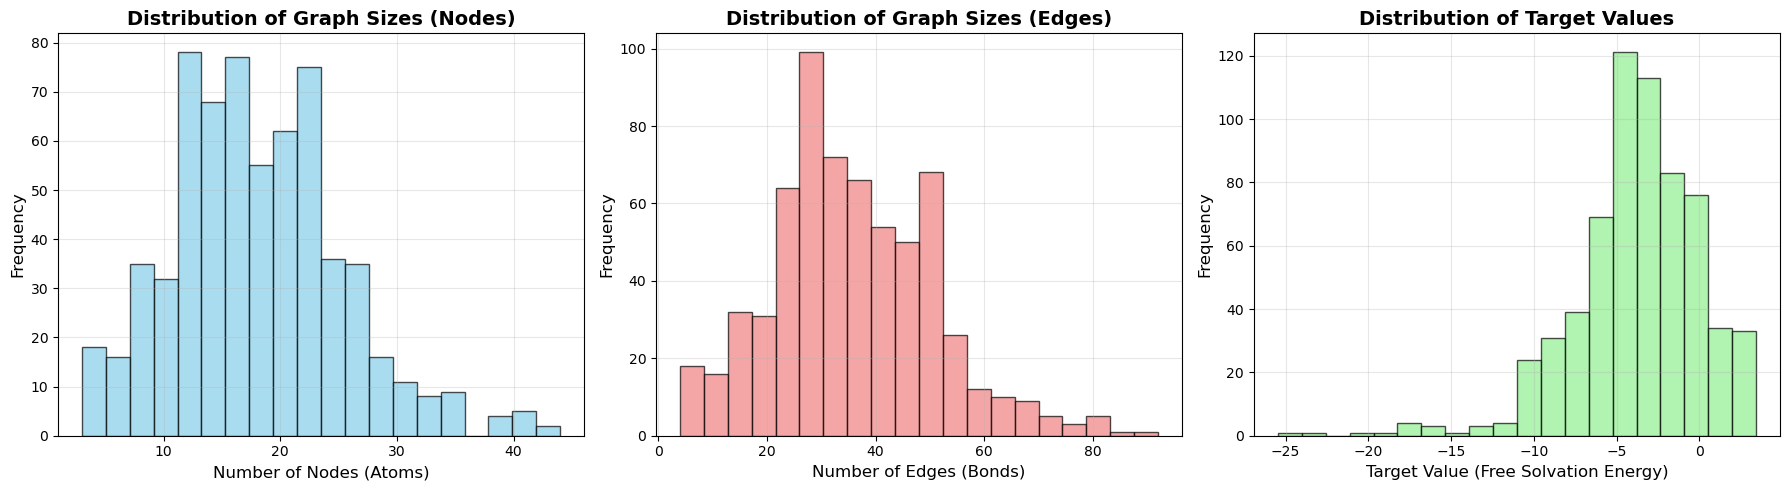

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 노드 수 분포
axes[0].hist(num_nodes, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Number of Nodes (Atoms)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Graph Sizes (Nodes)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 엣지 수 분포
axes[1].hist(num_edges, bins=20, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].set_xlabel('Number of Edges (Bonds)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Graph Sizes (Edges)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 타겟 값 분포
target_values = [data.y.item() for data in graph_dataset]
axes[2].hist(target_values, bins=20, edgecolor='black', alpha=0.7, color='lightgreen')
axes[2].set_xlabel('Target Value (Free Solvation Energy)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Distribution of Target Values', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. 요약 및 핵심 개념

### 9.1 배운 내용 정리

1. **SMILES**: 분자를 문자열로 표현하는 표준 방법
2. **Mol 객체**: RDKit의 핵심 분자 표현 구조
3. **원자 특징**: 원자 번호, degree, 수소 수, 전하, 방향족 여부 등
4. **결합 특징**: 결합 타입, 방향족, 공액, 고리 여부 등
5. **그래프 표현**: 원자 = 노드, 결합 = 엣지
6. **PyTorch Geometric**: GNN 학습을 위한 데이터 구조

### 9.2 GNN 학습을 위한 전처리 파이프라인

```
SMILES → Mol 객체 → 원자/결합 특징 추출 → 그래프 구조 생성 → PyTorch Geometric Data
```

### 9.3 주요 RDKit 함수

| 함수 | 설명 |
|------|------|
| `Chem.MolFromSmiles()` | SMILES에서 Mol 객체 생성 |
| `Chem.AddHs()` | 수소 원자 추가 |
| `mol.GetAtoms()` | 모든 원자 가져오기 |
| `mol.GetBonds()` | 모든 결합 가져오기 |
| `atom.GetAtomicNum()` | 원자 번호 |
| `atom.GetDegree()` | 연결된 원자 수 |
| `bond.GetBondType()` | 결합 타입 |
| `Draw.MolToImage()` | 분자 이미지 생성 |

### 9.4 헬퍼 함수

- `display_mol_with_options()`: 그리기 옵션을 임시 적용하여 분자 시각화
- `get_atom_features()`: 원자 특징 벡터 추출
- `get_bond_features()`: 결합 특징 벡터 추출
- `get_adjacency_matrix()`: 인접 행렬 생성

- `get_edge_list()`: 엣지 리스트 생성- 분자 생성 모델

- `mol_to_graph_data()`: SMILES를 PyTorch Geometric Data로 변환- 다양한 분자 특징(fingerprints, descriptors) 활용

- 분자 특성 예측 모델 학습

### 9.5 다음 단계- GNN 모델 구축 (GCN, GAT, GIN 등)


## 10. 연습 문제

### 문제 1: 카페인 분자 분석
SMILES: `CN1C=NC2=C1C(=O)N(C(=O)N2C)C`

1. Mol 객체를 생성하세요
2. 원자 수, 결합 수를 출력하세요
3. 분자량, LogP를 계산하세요
4. 그래프 데이터로 변환하세요

원자 수: 14
결합 수: 15
분자량: 194.19
LogP: -1.03

그래프 데이터:
노드: torch.Size([24, 6])
엣지: torch.Size([2, 50])


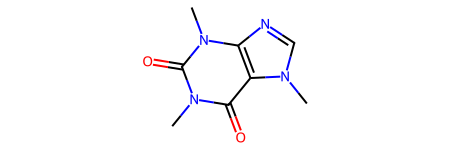

In [18]:
# 1. Mol 객체 생성
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
caffeine_mol = Chem.MolFromSmiles(caffeine_smiles)

# 2. 원자 수, 결합 수
print(f"원자 수: {caffeine_mol.GetNumAtoms()}")
print(f"결합 수: {caffeine_mol.GetNumBonds()}")

# 3. 분자량, LogP
print(f"분자량: {Descriptors.MolWt(caffeine_mol):.2f}")
print(f"LogP: {Descriptors.MolLogP(caffeine_mol):.2f}")

# 4. 그래프 데이터 변환
caffeine_graph = mol_to_graph_data(caffeine_smiles)
print(f"\n그래프 데이터:")
print(f"노드: {caffeine_graph.x.shape}")
print(f"엣지: {caffeine_graph.edge_index.shape}")

# 시각화
caffeine_mol

### 문제 2: 여러 분자 비교

다음 3개 분자의 특성을 비교하세요:
- 메탄올: `CO`
- 에탄올: `CCO`
- 프로판올: `CCCO`

비교할 특성: 분자량, LogP, 수소 결합 공여체/수용체 수

In [19]:
alcohols = {
    '메탄올': 'CO',
    '에탄올': 'CCO',
    '프로판올': 'CCCO'
}

results = []
for name, smiles in alcohols.items():
    mol = Chem.MolFromSmiles(smiles)
    results.append({
        '분자': name,
        'SMILES': smiles,
        '분자량': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'H-Donor': Descriptors.NumHDonors(mol),
        'H-Acceptor': Descriptors.NumHAcceptors(mol)
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

  분자 SMILES    분자량    LogP  H-Donor  H-Acceptor
 메탄올     CO 32.042 -0.3915        1           1
 에탄올    CCO 46.069 -0.0014        1           1
프로판올   CCCO 60.096  0.3887        1           1
